# 【第２回目　課題１】Kerasを用いた深層学習 (1): 全結合編

第2回目の課題１では，前回の課題1と同じ問題に対して，最も簡単な深層学習フレームワークと言われている<a href="https://keras.io/ja/">Keras</a>を用いて，取り組んでみましょう．

まずは，<a href="https://keras.io/ja/">Kerasの公式日本語ドキュメント</a>を見てみましょう．

Kerasには，<a href="https://keras.io/ja/getting-started/sequential-model-guide/">Sequential model</a> と <a href="https://keras.io/ja/getting-started/functional-api-guide/">Functional API </a>を使うの２つの書き方があります．

レイヤーを単純につなげていくだけの簡単なモデルの場合は，Sequential model で十分ですので，今回はSequential model を使うことにします．

課題としては，前回同様に
全結合層＋ReLU＋2乗誤差関数 のネットワークを考えてみます．
全結合層を使って任意の関数の近似を行います．

最初に keras の実行に必要な モジュールを import します．
Sequential, Denseは簡単に使えるように クラス単位でimportしておきます．
numpyはデータの生成に必要なので，最初に指定します．

In [1]:
import numpy as np
import time

import keras
from keras.models import Sequential
from keras.layers import Dense, Activation

Using TensorFlow backend.


前回と違って，当然ですが，全結合層クラスはKearsに含まれているので，実装は不要です．
Kerasでは，Dense が fcに相当します．
```python
from keras.layers import Dense
```

次に学習するネットワークを記述してみましょう．
前回は以下のように1x10+ReLU +10x10+ReLU + 10x1 の３層となっていました．
```python
fc1=Fc(1,20)
fc2=Fc(20,20)
fc3=Fc(20,1,False)
```

なお，前回は，fcにはデフォルトでReluが付いていました．第３引数がFalseの時だけReluなしでした．

まず，Sequential オブジェクトを作って，そこに，layer を add していきます．
fc は Dense と表記します．ReLuが必要なは，activation='relu' のオプションを指定します．
Denseの場合は，最初だけ入力次元を input_dim で指定しますが，そのあとは，前層の出力次元＝入力次元　ですので，省略して，出力次元のみを記述します．

なお，Kerasでのパラメータ初期値の設定方法は，<a href="https://keras.io/ja/initializers/#glorot_uniform">kernel_initializer='glorot_uniform'</a> となっています．Heの初期値がいい場合は，<a href="https://keras.io/ja/initializers/#he_normal">kernel_initializer='he_normal'</a>と指定する必要があります．

In [2]:
model = Sequential()
model.add(Dense(20, input_dim=1, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(1))

Kerasでは，簡単に定義したネットワークを図で表示することができます．
次のようにすると，modelの中身を表示できます．
なお，
```
model.add(Dense(20, activation='relu'))
```
のようにDenseレイヤ中でオプションで指定した活性化関数は表示されません．

表示したい場合は，
```
model.add(Dense(20))
model.add(Activation('relu'))
```
のように別々にレイヤとして追加する必要があります．

あと，データのinput/output shape が表示されていますが，
最初の次元は batchsize を表していて，モデル定義時には未指定ですので，常に None と表示されます．

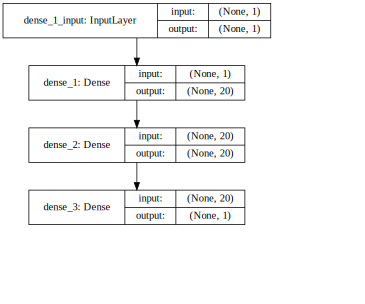

In [3]:
# model の表示
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, show_layer_names=True).create(prog='dot', format='svg'))

In [4]:
# モデル名.summary() でも表示できます．
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 20)                40        
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


モデル定義が終わったら，<a href="https://keras.io/ja/getting-started/sequential-model-guide/#_1">compile</a>が必要です．
compile では，SGD, adamなどの最適化手法(optimizer)の指定，損失関数(loss function)の指定を行います．
complieの詳細は，<a href="https://keras.io/ja/models/sequential/#compile">こちら</a>です．

利用可能な <a href="https://keras.io/ja/optimizers/">optimizer</a> を確認しておきましょう．
標準SDGとモーメンタムSDGの区別はありません．momentum rate の指定で区別できます．
デフォルトでは，momentum rate=0.0 ですので，標準SDGになります．
mometum=0.9 とすれば，一般的なモーメンタムSDGとなります．

decay は，Weight Decay の正則化パラメータですが，1e-6 など通常は小さい値を指定しますが，最初はdecayを使わないことにして 0 としておきます．

損失関数は，回帰問題なので，最小２乗誤差(mean_squared_error) を使います．<a href="https://keras.io/ja/losses/">損失関数一覧</a>に使える関数が書かれています．

In [5]:
sgd = keras.optimizers.SGD(lr=0.0001, momentum=0, decay=0.0)
model.compile(optimizer=sgd, loss='mean_squared_error')

モデル定義が終わったので，次に，近似する関数の定義を行って，学習データ(training data)，検証データ(validation data)を生成します．データの定義は，基本的に前回と同じです．

In [6]:
def f(x):
    return 0.5*(x-2)**2-5

def f2(x):
    return 0.5*(x + 3)**2 - 8

def f3(x):
    return np.sin(x)/x

In [7]:
def generate_function_and_train_test_data(pattern = "1"):
    if pattern == "1":
        X_train = np.arange(-10,10,0.01,dtype=np.float32)
        Y_train = f(X_train)
        # X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
        X_train = np.reshape(X_train,[-1,1])   # (2000,)  -> (2000,1)
        Y_train = np.reshape(Y_train,[-1,1]) 
        num_train = np.size(X_train)

        # テスト用の x も準備します．
        X_val = np.arange(-8,8,0.1,dtype=np.float32)
        Y_val = f(X_val)
        X_val = np.reshape(X_val,[-1,1])
        Y_val = np.reshape(Y_val,[-1,1])
        num_val = np.size(X_val)
        
        return X_train, Y_train, X_val, Y_val, f
    
    elif pattern == "2":
        X_train = np.arange(-10,10,0.01,dtype=np.float32)
        Y_train = f2(X_train)
        # X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
        X_train = np.reshape(X_train,[-1,1])   # (2000,)  -> (2000,1)
        Y_train = np.reshape(Y_train,[-1,1]) 
        num_train = np.size(X_train)

        # テスト用の x も準備します．
        X_val = np.arange(-8,8,0.1,dtype=np.float32)
        Y_val = f(X_val)
        X_val = np.reshape(X_val,[-1,1])
        Y_val = np.reshape(Y_val,[-1,1])
        num_val = np.size(X_val)
        
        return X_train, Y_train, X_val, Y_val, f2
    
    elif pattern == "3":
        X_train = np.arange(-10,10,0.01,dtype=np.float32)
        Y_train = f3(X_train)
        # X_train, Y_trainは１次元配列なので，reshapeで ２次元の(n,dim)に変換します．dim=1です．
        X_train = np.reshape(X_train,[-1,1])   # (2000,)  -> (2000,1)
        Y_train = np.reshape(Y_train,[-1,1]) 
        num_train = np.size(X_train)

        # テスト用の x も準備します．
        X_val = np.arange(-8,8,0.1,dtype=np.float32)
        Y_val = f(X_val)
        X_val = np.reshape(X_val,[-1,1])
        Y_val = np.reshape(Y_val,[-1,1])
        num_val = np.size(X_val)
        
        return X_train, Y_train, X_val, Y_val, f3

いよいよ，学習です．

Kerasでは学習ループは書く必要はありません．
<a href="https://keras.io/ja/models/sequential/#fit"> fit </a> を利用すると，関数の中で学習ループを回してくれます．
引数で，batch size, epoch数も指定します．

```python
model.fit(X_train, Y_train, batch_size=20, epochs=100, validation_data=(X_val,Y_val))
```
で実行可能です．コマンドラインからの実行ならこれで十分でしょう．
ただし，Jupyter上での実行だと，epoch数分のloss 値が出力されてブラウザ上での表示が大変なことになります．

そこで <a href="https://keras.io/ja/callbacks/">callback</a>を使って，前回の誤差(loss)グラフ表示を実現します．(callback関数定義の詳細は理解不要です．) callback をうまく使えば，学習ループはKerasのものを利用しつつ，学習ループの途中での処理を追加することができます．
```python
model.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
```
として，show_graphを呼ぶようにして，代わりにverbose=0で途中経過のテキスト表示は中止します．


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display
import keras

# callback のクラス ShowGraphを定義
# グラフ表示で必要なので，コンストラクタで，model, 最大エポック数 を受け取っておく．
# model は，学習途中のパラメータを用いて， y=f(x)を描画するのに必要．
class ShowGraph(keras.callbacks.Callback):
    def __init__(self,model,max_epoch, pattern, X_val, f):
        # 表示エリアの設定
        self.fig = plt.figure(figsize=(8,4))
        self.fig1 = self.fig.add_subplot(121)
        self.fig1.axis([0, max_epoch, 0, 50])
        self.fig2 = self.fig.add_subplot(122)
        self.fig2.axis([-8,8,-10,30])
        self.fig1.set_title('loss')
        self.fig1.set_ylabel('loss')
        self.fig1.set_xlabel('epoch')
        self.model = model
        self.max_epoch = max_epoch
        self.start = time.time()
        self.pattern = pattern
        self.X_val = X_val
        self.f = f
    
    # 学習の最初に呼び出される
    def on_train_begin(self, logs={}):
        self.losses = []
        self.losses_val = []
        self.n_epoch = []
    
    # 各epochの最後に呼び出される
    def on_epoch_end(self, epoch, logs={}):
        self.n_epoch.append(epoch)
        self.losses.append(logs.get('loss'))
        self.losses_val.append(logs.get('val_loss'))     
        self.loss_val = logs.get('val_loss')
    
        display.clear_output(wait = True)
        self.fig1.plot(self.n_epoch,self.losses,"b", label="train loss")
        self.fig1.plot(self.n_epoch,self.losses_val,"r", label="validation loss")
        self.fig1.legend(loc="upper right")
        Y_pred = self.model.predict_on_batch(self.X_val)
        x0 = np.reshape(X_val,[-1])
        y0 = np.reshape(Y_pred,[-1])
        self.fig2.plot(x0,y0,"b", label="approximated function")
        self.fig2.plot(x0,self.f(x0),"r", label="original function")
        if self.pattern == "1":
            self.fig2.set_title('y = 0.5(x-2)^2 - 5')
        elif self.pattern == "2":
            self.fig2.set_title('y = 0.5(x+3)^2 - 8')
        elif self.pattern == "3":
            self.fig2.set_title('y = sin(x)/x')
        self.fig2.legend(loc="upper right")
        self.fig2.set_ylabel('f(x)')
        self.fig2.set_xlabel('x')
        display.display(self.fig)
        if epoch < self.max_epoch - 1:
            self.fig1.cla()
            self.fig2.cla()
    
    # デストラクタ(オブジェクトが消滅時に実行される)  
    # グラフが２つ表示されるのを防止．さらに最終val loss値の表示．
    def __del__(self):
        display.clear_output(wait = True)
        print("loss_val: {}".format(self.loss_val)) 
        print('Time: {}'.format(time.time() - self.start))

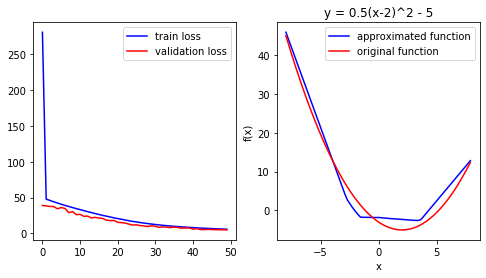

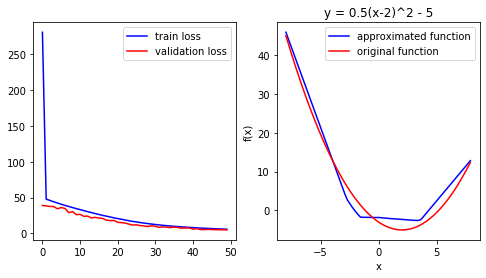

In [9]:
X_train, Y_train, X_val, Y_val, f = generate_function_and_train_test_data()
num_epoch = 50
show_graph = ShowGraph(model,num_epoch, pattern="1", X_val=X_val, f=f)
model.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph

### 課題1
以下の小問の(1)-(2)を解答せよ．

1. OptimizerをモーメンタムSDG (momentum=0.9), RMSprop, Adamに変更して，ノーマルなSDGとの違いを観察せよ．
1. 関数 $f(x)$ を自由に書き換え，実行せよ．2通りの $f(x)$ で試してみよ．

### 課題1. 1 OptimizerをモーメンタムSDG (momentum=0.9), RMSprop, Adamに変更して，ノーマルなSDGとの違いを観察せよ．

### モーメンタムSGDを利用した場合

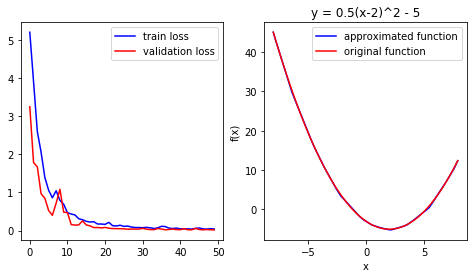

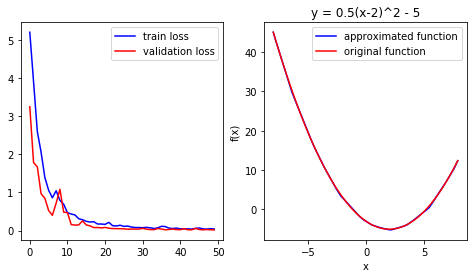

In [10]:
sgd_momentum = keras.optimizers.SGD(lr=0.0001, momentum=0.9, decay=0)  # momentamありの場合．
model.compile(optimizer=sgd_momentum, loss='mean_squared_error')

show_graph = ShowGraph(model,num_epoch, pattern="1", X_val=X_val, f=f)
model.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph

### RMSprop を利用した場合

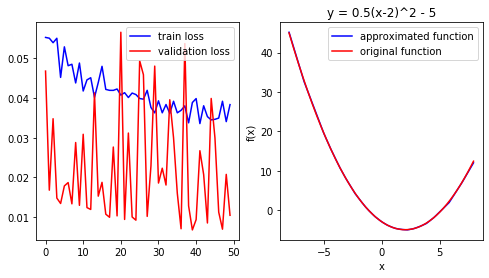

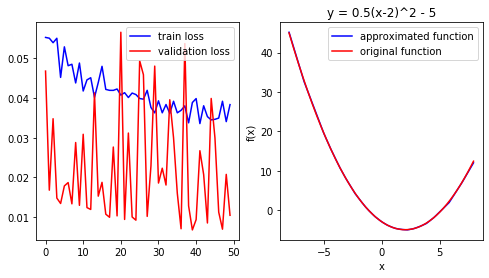

In [11]:
rmsprop = keras.optimizers.RMSprop()
model.compile(optimizer=rmsprop, loss='mean_squared_error')

show_graph = ShowGraph(model,num_epoch, pattern="1", X_val=X_val, f=f)
model.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph

### Adamを利用した場合

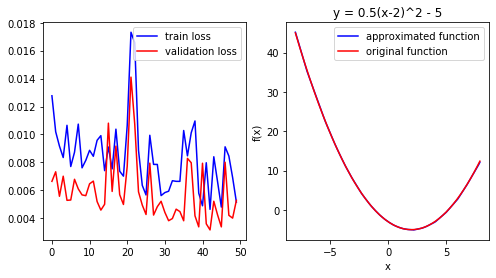

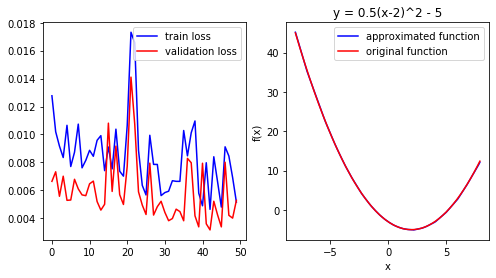

In [12]:
adam = keras.optimizers.Adam()
model.compile(optimizer=adam, loss='mean_squared_error')

show_graph = ShowGraph(model,num_epoch, pattern="1", X_val=X_val, f=f)
model.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph

### 課題1 2. 関数  𝑓(𝑥)  を自由に書き換え，実行せよ．2通りの  𝑓(𝑥)  で試してみよ

$f(x)= 0.5\times(x+3)^2 - 8$ とする 勾配の更新方法はSGD

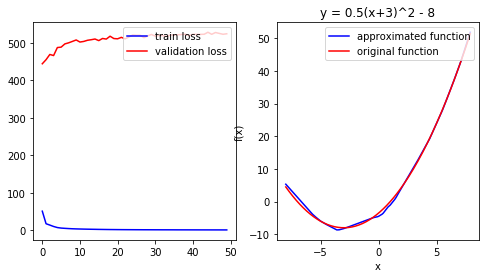

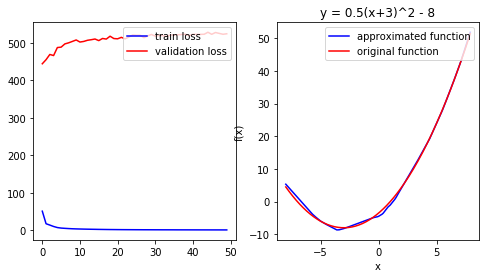

In [13]:
model.compile(optimizer=sgd, loss='mean_squared_error')

X_train, Y_train, X_val, Y_val, f = generate_function_and_train_test_data(pattern="2")

show_graph = ShowGraph(model,num_epoch, pattern="2", X_val=X_val, f=f)
model.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph

$f(x) = \dfrac{\sin(x)}{x}$ とする． 勾配の更新方法はSGD

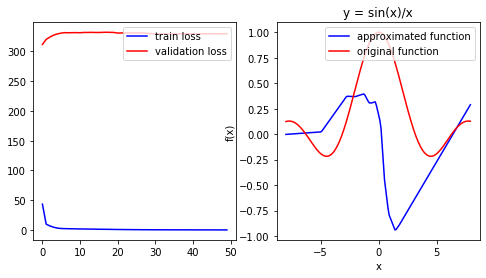

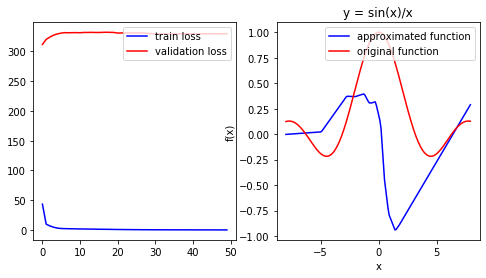

In [14]:
model.compile(optimizer=sgd,loss='mean_squared_error')

X_train, Y_train, X_val, Y_val, f = generate_function_and_train_test_data(pattern="3")

show_graph = ShowGraph(model,num_epoch, pattern="3", X_val=X_val, f=f)
model.fit(X_train, Y_train, batch_size=20, epochs=num_epoch, validation_data=(X_val,Y_val), verbose=0, callbacks=[show_graph])
del show_graph